In [174]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

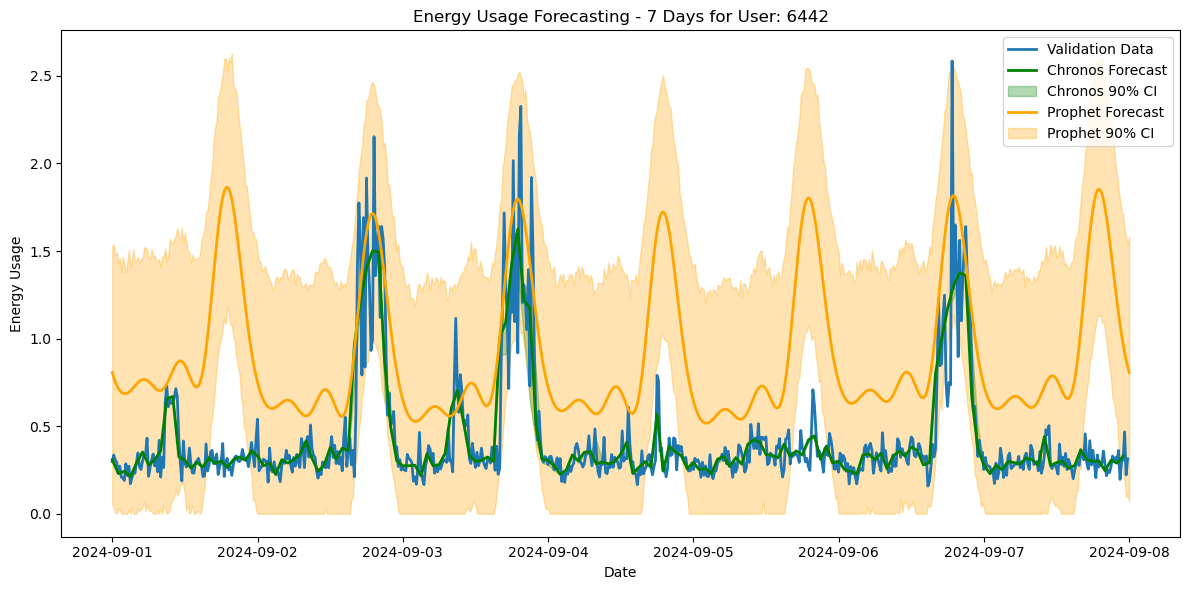

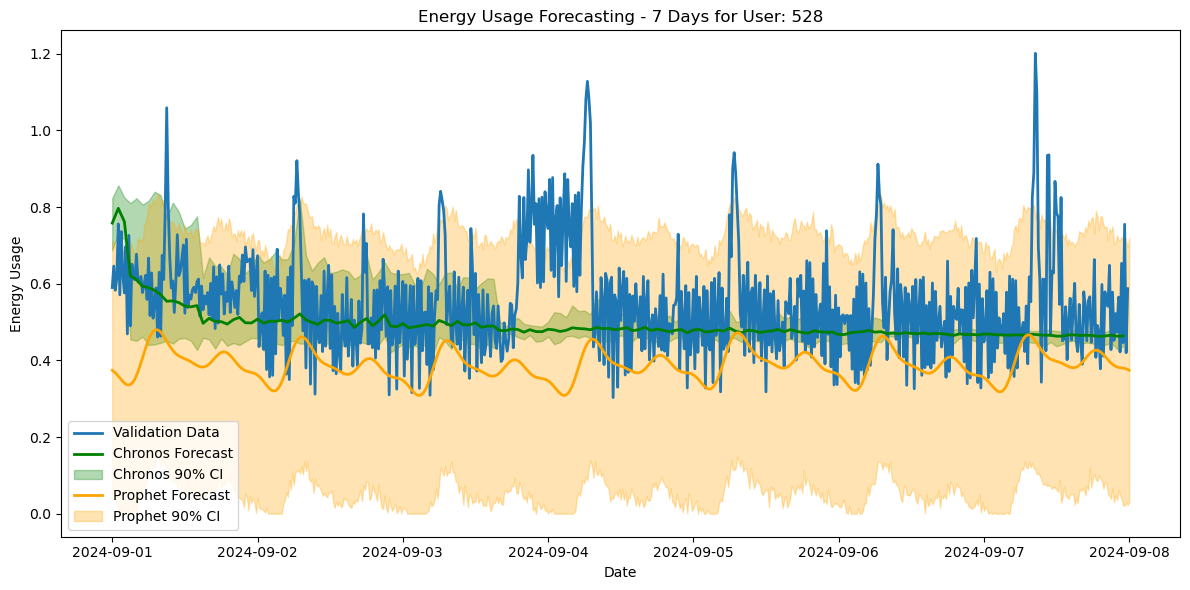

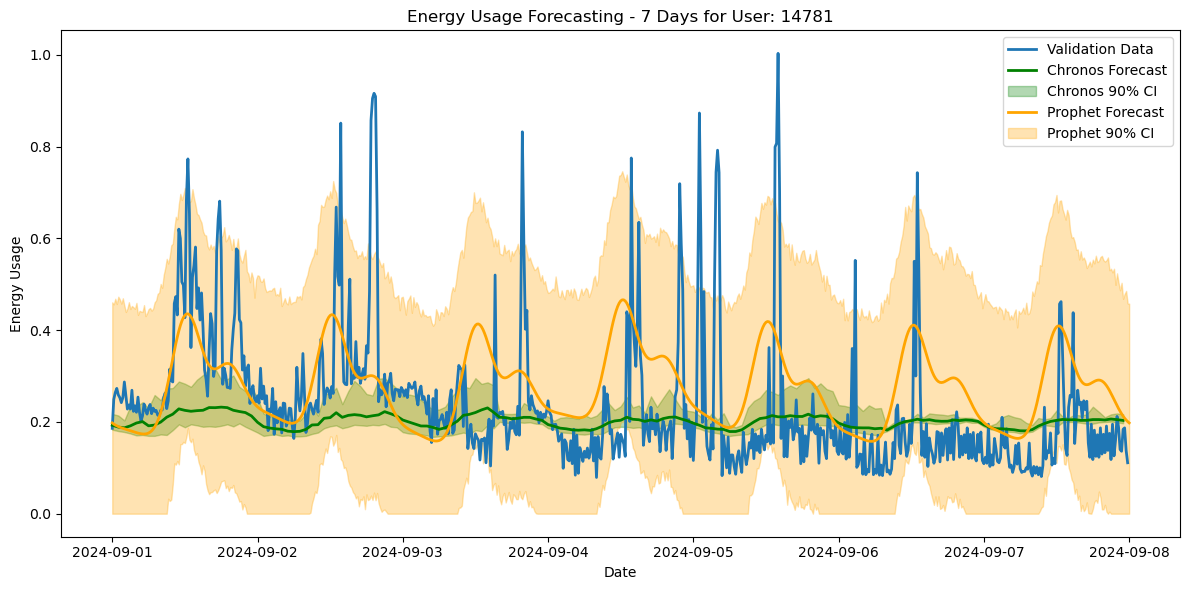

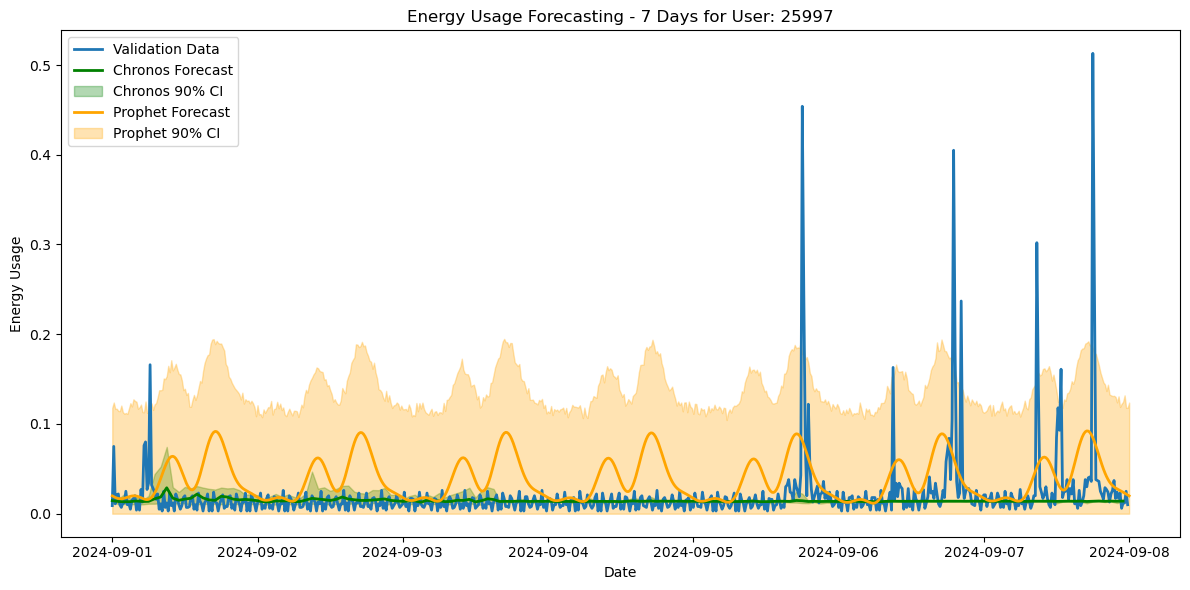

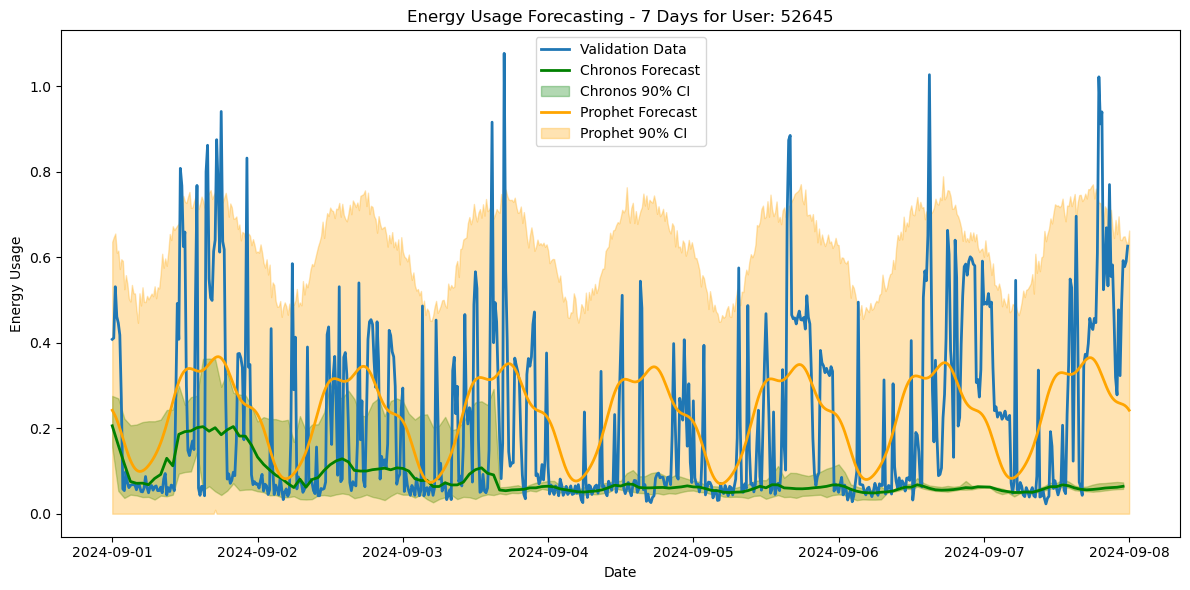

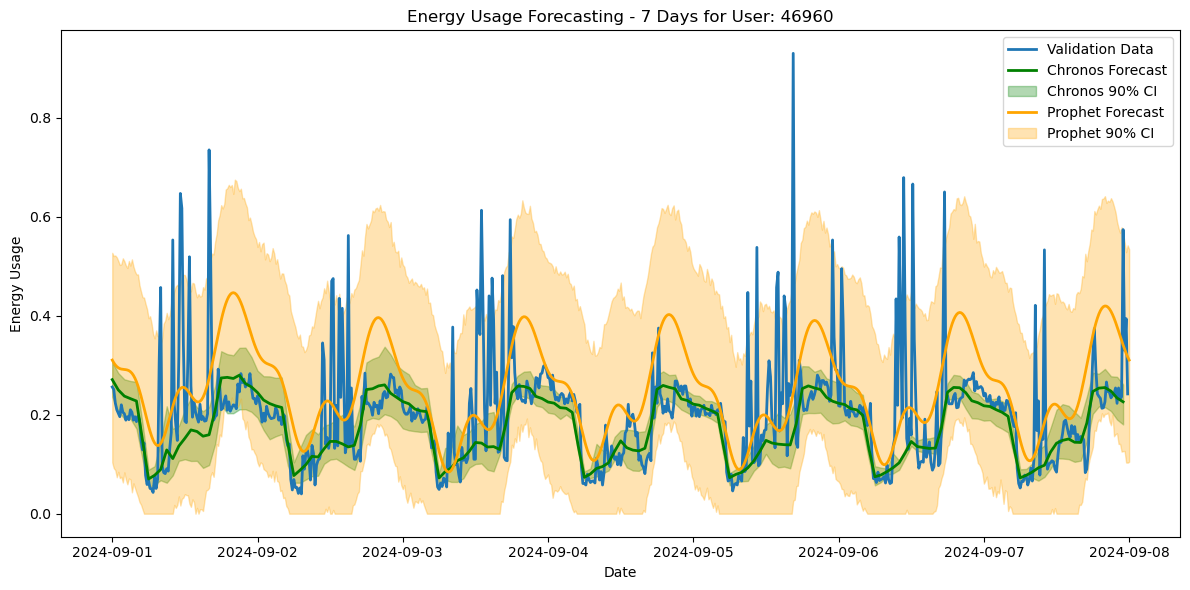

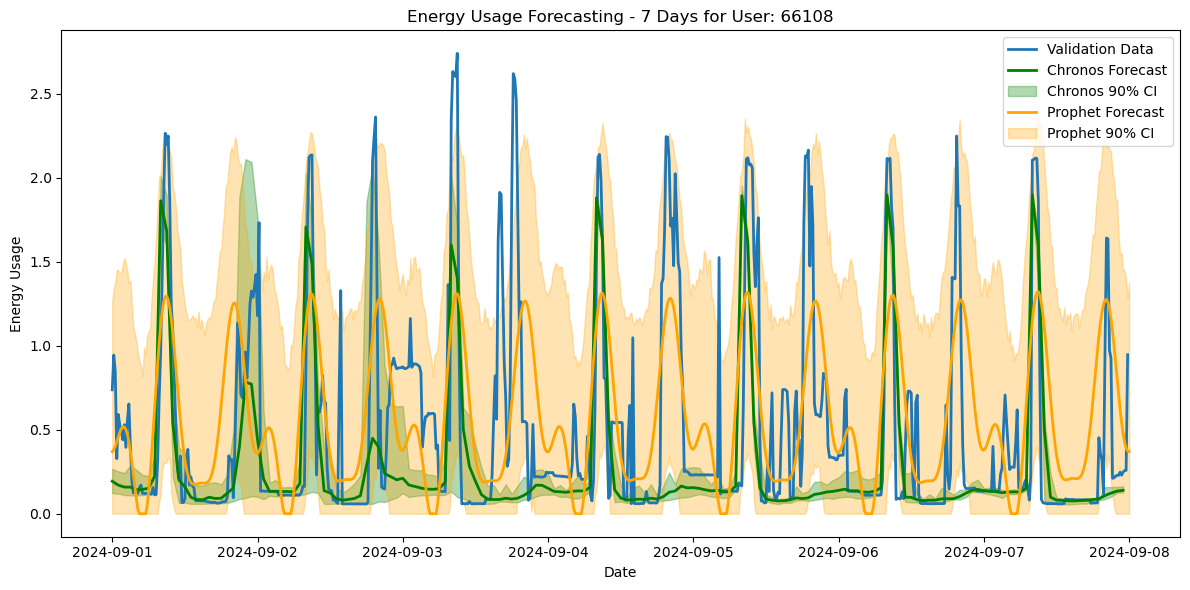

In [179]:
user_ids = [6442, 528, 14781, 25997, 52645, 46960, 66108]

for user_id in user_ids:
    training_data = pd.read_csv("../../data/usage_forecasting/user_data_" + str(user_id) + "_training.csv")
    validation_data = pd.read_csv("../../data/usage_forecasting/user_data_" + str(user_id) + "_validation.csv", header=None)
    #rename validation_data columns
    validation_data.columns = ['datetime', 'value',"status"]
    chronos_forecast = pd.read_csv("../../data/usage_forecasting/user_data_" + str(user_id) + "_forecast_chronos.csv")
    prophet_forecast = pd.read_csv("../../data/usage_forecasting/user_data_" + str(user_id) + "_forecast_prophet.csv")
    
    # Convert datetime columns to datetime objects first
    validation_data['datetime'] = pd.to_datetime(validation_data['datetime'], format='%m/%d/%y %H:%M')
    chronos_forecast['datetime'] = pd.to_datetime(chronos_forecast['datetime'])
    prophet_forecast['ds'] = pd.to_datetime(prophet_forecast['ds'])
    
    # Select entries from prophet_forecast between 2024-09-01 00:00:00 and 2024-09-08 00:00:01
    start_date = pd.Timestamp("2024-09-01 00:00:00")
    end_date = pd.Timestamp("2024-09-08 00:00:01")
    prophet_forecast_week = prophet_forecast[(prophet_forecast['ds'] >= start_date) & (prophet_forecast['ds'] <= end_date)]
    
    # plot first 7 days of validation data and chronos forecast with confidence intervals
    plt.figure(figsize=(12, 6))
    plt.plot(validation_data['datetime'][:24*4*7], validation_data['value'][:24*4*7], label='Validation Data', linewidth=2)
    plt.plot(chronos_forecast['datetime'], chronos_forecast['usage_forecast_mean'], label='Chronos Forecast', linewidth=2, color='green')

    # Add 90% confidence intervals with matching color
    plt.fill_between(chronos_forecast['datetime'], 
                    chronos_forecast['usage_lower_95'], 
                    chronos_forecast['usage_upper_95'], 
                    alpha=0.3, label='Chronos 90% CI', color='green')

    # include yhat, yhat_lower, yhat_upper from prophet forecast with matching colors
    plt.plot(prophet_forecast_week['ds'], prophet_forecast_week['yhat'], label='Prophet Forecast', color='orange', linewidth=2)
    plt.fill_between(prophet_forecast_week['ds'], 
                    prophet_forecast_week['yhat_lower'], 
                    prophet_forecast_week['yhat_upper'], 
                    alpha=0.3, label='Prophet 90% CI', color='orange')

    plt.xlabel('Date')
    plt.ylabel('Energy Usage')
    plt.title('Energy Usage Forecasting - 7 Days for User: ' + str(user_id))
    plt.legend()
    plt.tight_layout()
    plt.show()

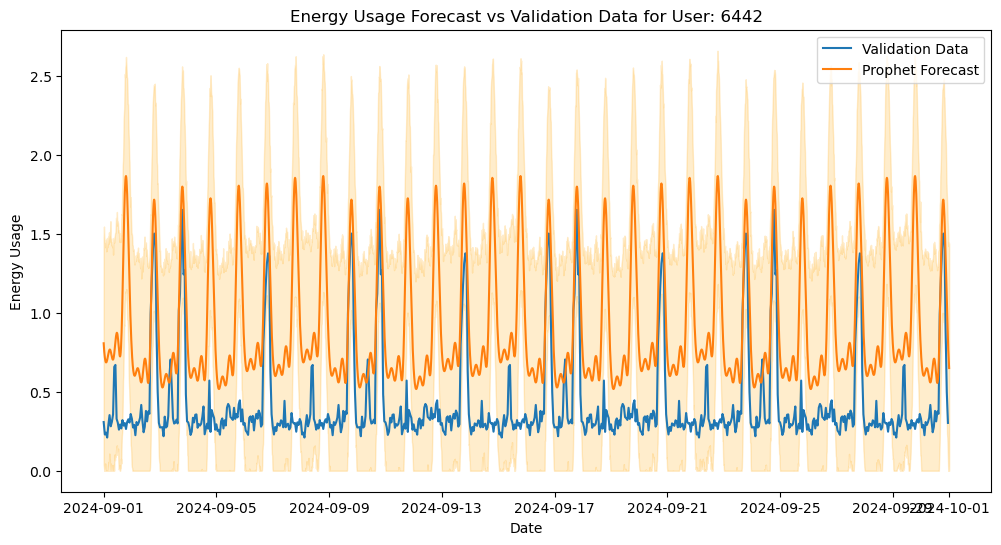

Actual Usage (30 days): 305.18725 kWh
Forecasted Usage (30 days): 649.2728620212016 kWh
Ratio (Forecast/Actual): 2.1274573627214166
Forecasted Usage Lower Bound (30 days): 159.4347252911559 kWh
Forecasted Usage Upper Bound (30 days): 1175.9824778778743 kWh
Mean Absolute Error (30 days): 0.4988180332386725 kWh
Root Mean Square Error (30 days): 0.6011930686821635 kWh
(2881, 3)
(2881, 19)
Coverage (30 days): 0.834


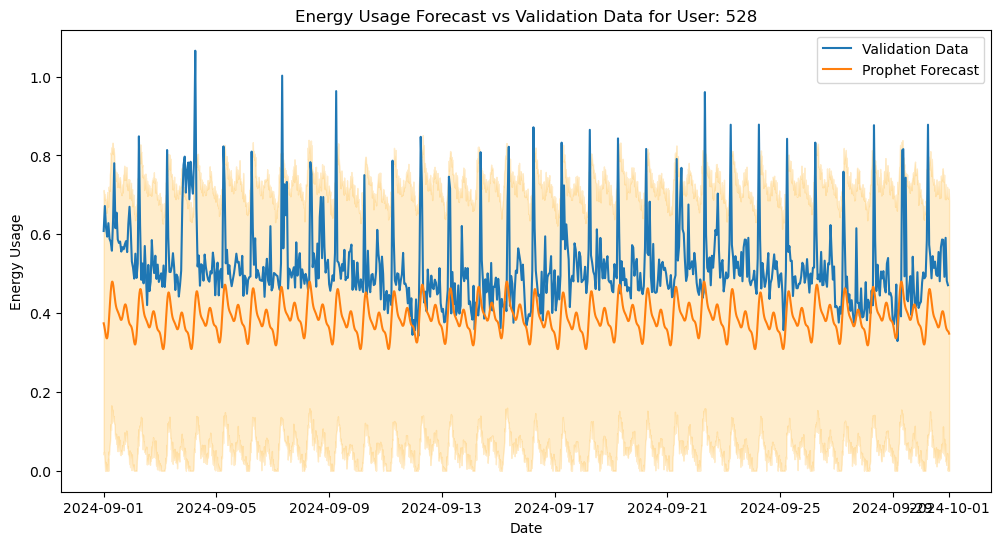

Actual Usage (30 days): 372.339 kWh
Forecasted Usage (30 days): 279.78139481633696 kWh
Ratio (Forecast/Actual): 0.7514157657842369
Forecasted Usage Lower Bound (30 days): 37.545680326461635 kWh
Forecasted Usage Upper Bound (30 days): 523.401532233654 kWh
Mean Absolute Error (30 days): 0.1504286339969742 kWh
Root Mean Square Error (30 days): 0.19037831986507533 kWh
(2881, 3)
(2881, 19)
Coverage (30 days): 0.935


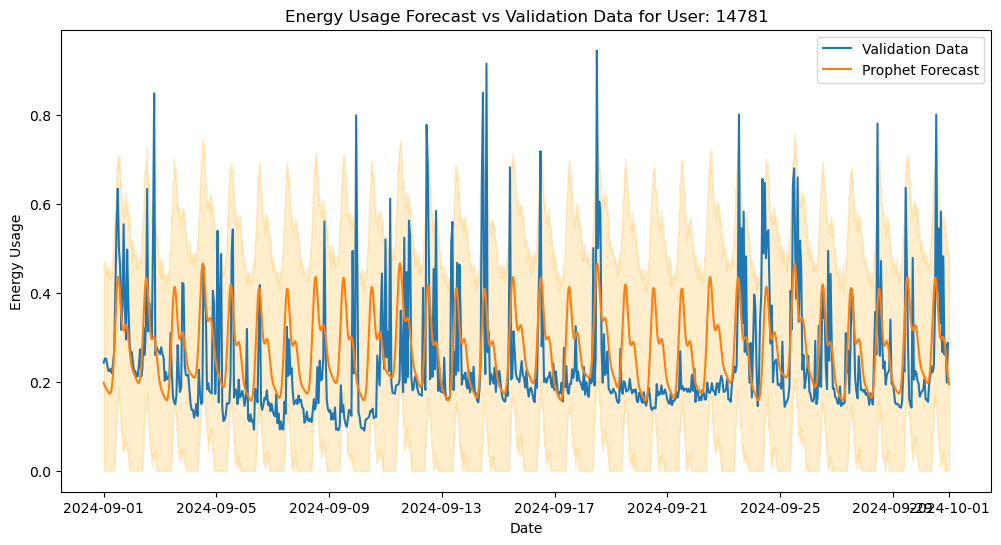

Actual Usage (30 days): 173.3865 kWh
Forecasted Usage (30 days): 198.08719838164922 kWh
Ratio (Forecast/Actual): 1.1424603321576317
Forecasted Usage Lower Bound (30 days): 27.050097208350273 kWh
Forecasted Usage Upper Bound (30 days): 390.94577476302385 kWh
Mean Absolute Error (30 days): 0.11179607098706672 kWh
Root Mean Square Error (30 days): 0.16083942019141725 kWh
(2881, 3)
(2881, 19)
Coverage (30 days): 0.932


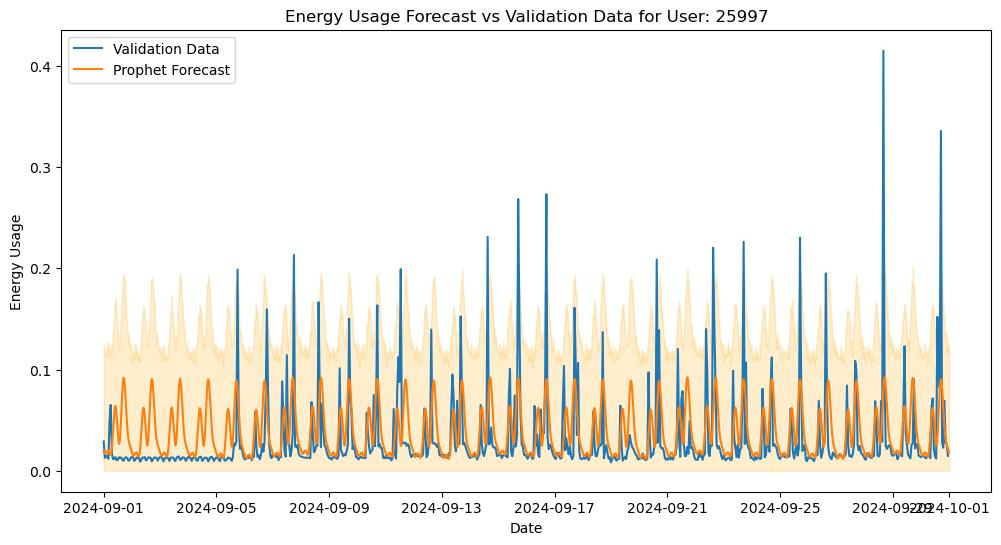

Actual Usage (30 days): 21.574000000000005 kWh
Forecasted Usage (30 days): 27.789489139087863 kWh
Ratio (Forecast/Actual): 1.2881009149479863
Forecasted Usage Lower Bound (30 days): 0.000813044476096025 kWh
Forecasted Usage Upper Bound (30 days): 99.3805054917087 kWh
Mean Absolute Error (30 days): 0.029039975518141376 kWh
Root Mean Square Error (30 days): 0.05684025362864433 kWh
(2881, 3)
(2881, 19)
Coverage (30 days): 0.959


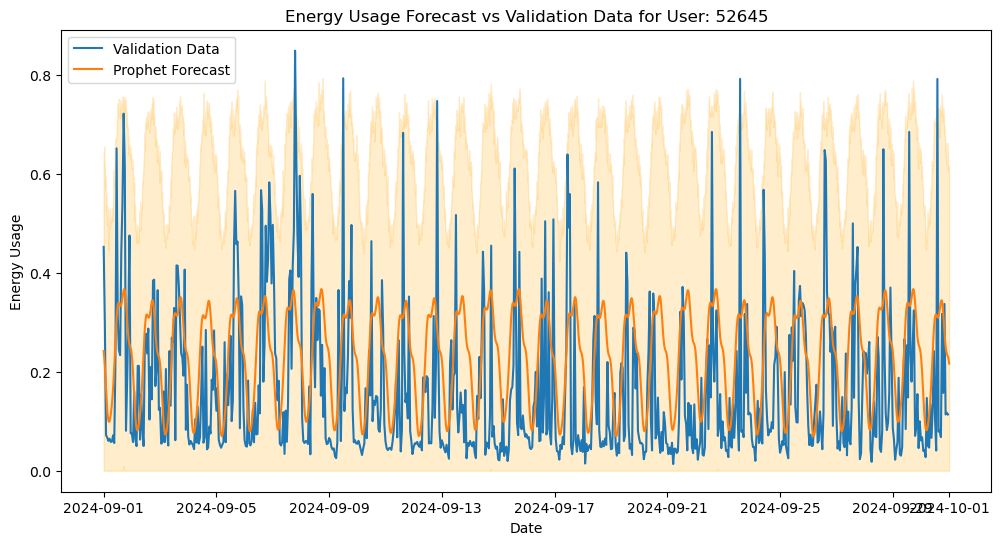

Actual Usage (30 days): 116.8415 kWh
Forecasted Usage (30 days): 168.3262014330101 kWh
Ratio (Forecast/Actual): 1.440637114663969
Forecasted Usage Lower Bound (30 days): 0.004498561314609375 kWh
Forecasted Usage Upper Bound (30 days): 451.29045718320964 kWh
Mean Absolute Error (30 days): 0.158333681484449 kWh
Root Mean Square Error (30 days): 0.1953924167703395 kWh
(2881, 3)
(2881, 19)
Coverage (30 days): 0.974


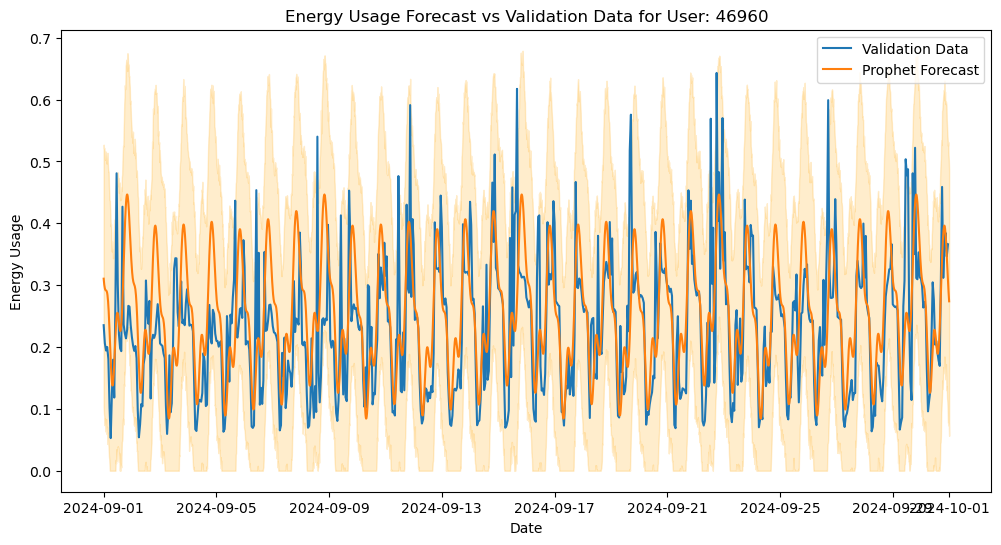

Actual Usage (30 days): 166.52749999999997 kWh
Forecasted Usage (30 days): 181.86502577709624 kWh
Ratio (Forecast/Actual): 1.0921020598825795
Forecasted Usage Lower Bound (30 days): 38.959831989464014 kWh
Forecasted Usage Upper Bound (30 days): 340.27657188628905 kWh
Mean Absolute Error (30 days): 0.07976548226575636 kWh
Root Mean Square Error (30 days): 0.11807194005507021 kWh
(2881, 3)
(2881, 19)
Coverage (30 days): 0.948


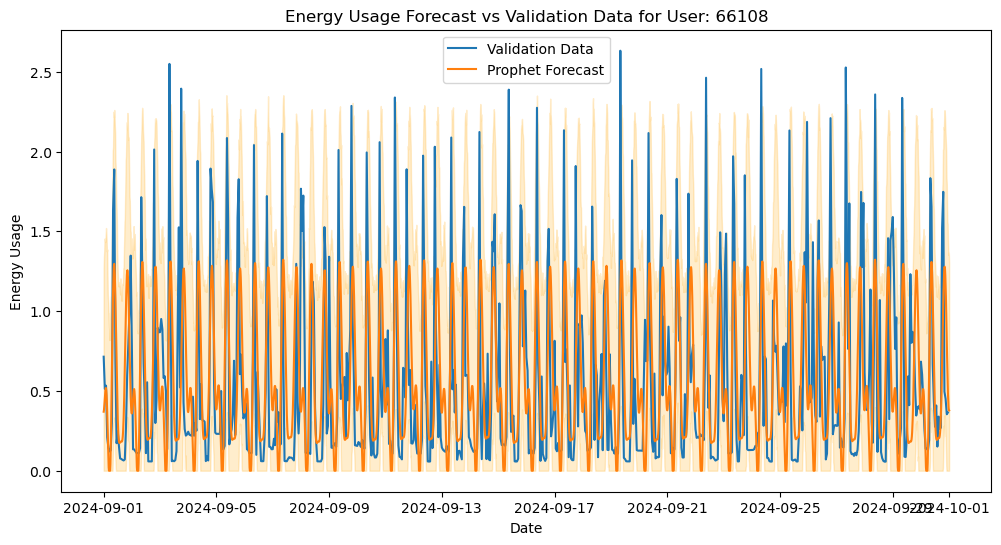

Actual Usage (30 days): 395.6495 kWh
Forecasted Usage (30 days): 411.2816592846084 kWh
Ratio (Forecast/Actual): 1.0395101201558663
Forecasted Usage Lower Bound (30 days): 36.2944145128034 kWh
Forecasted Usage Upper Bound (30 days): 1101.1259041659187 kWh
Mean Absolute Error (30 days): 0.41139480526112265 kWh
Root Mean Square Error (30 days): 0.5481246378995234 kWh
(2881, 3)
(2881, 19)
Coverage (30 days): 0.901


In [178]:
# Select entries from prophet_forecast between 2024-09-01 00:00:00 and 2024-10-01 00:00:01
start_date = pd.Timestamp("2024-09-01 00:00:00")
end_date = pd.Timestamp("2024-10-01 00:00:01")

for user_id in user_ids:
    
    validation_data = pd.read_csv("../../data/usage_forecasting/user_data_" + str(user_id) + "_validation.csv", header=None)
    validation_data.columns = ['datetime', 'value',"status"]
    
    prophet_forecast = pd.read_csv("../../data/usage_forecasting/user_data_" + str(user_id) + "_forecast_prophet.csv")

    # Convert datetime columns to datetime objects first
    validation_data['datetime'] = pd.to_datetime(validation_data['datetime'], format='%m/%d/%y %H:%M')
    prophet_forecast['ds'] = pd.to_datetime(prophet_forecast['ds'])

    #resample validation data to hourly averages
    validation_data_hourly = validation_data.drop(columns=["status"])
    validation_data_hourly = validation_data_hourly.resample('H', on='datetime').mean().reset_index()

    prophet_forecast_sept = prophet_forecast[(prophet_forecast['ds'] >= start_date) & (prophet_forecast['ds'] <= end_date)]

    # plot 30 days of validation data and the prophet forecast
    plt.figure(figsize=(12, 6))
    plt.plot(validation_data_hourly['datetime'][:30*24], validation_data_hourly['value'][:30*24], label='Validation Data')
    plt.plot(prophet_forecast_sept['ds'], prophet_forecast_sept['yhat'], label='Prophet Forecast')
    plt.fill_between(prophet_forecast_sept['ds'], prophet_forecast_sept['yhat_lower'], prophet_forecast_sept['yhat_upper'], alpha=0.2, color='orange')
    plt.xlabel('Date')
    plt.ylabel('Energy Usage')
    plt.title('Energy Usage Forecast vs Validation Data for User: ' + str(user_id))
    plt.legend()
    plt.show()
    

    # For validation data (15-min intervals): 30 days * 24 hours * 4 intervals = 2,880 points
    usage_actual_sum = validation_data['value'][:30*24*4].sum()

    # For prophet forecast: use all September data (already filtered by date)
    usage_forecast_sum = prophet_forecast_sept['yhat'].sum()

    usage_forecast_lower = prophet_forecast_sept['yhat_lower'].sum()
    usage_forecast_upper = prophet_forecast_sept['yhat_upper'].sum()
    
    print(f"Actual Usage (30 days): {usage_actual_sum * 0.25} kWh")
    print(f"Forecasted Usage (30 days): {usage_forecast_sum * 0.25} kWh")
    print(f"Ratio (Forecast/Actual): {(usage_forecast_sum / usage_actual_sum)}")
    print(f"Forecasted Usage Lower Bound (30 days): {usage_forecast_lower * 0.25} kWh")
    print(f"Forecasted Usage Upper Bound (30 days): {usage_forecast_upper * 0.25} kWh")
    
    mae = mean_absolute_error(validation_data['value'][:30*24*4], prophet_forecast_sept['yhat'][:-1])
    print(f"Mean Absolute Error (30 days): {mae} kWh")

    rmse = root_mean_squared_error(validation_data['value'][:30*24*4], prophet_forecast_sept['yhat'][:-1])
    print(f"Root Mean Square Error (30 days): {rmse} kWh")
    
    # Filter validation data by datetime values (not index)
    validation_mask = (validation_data['datetime'] >= start_date) & (validation_data['datetime'] <= end_date)
    validation_aligned = validation_data[validation_mask]

    print(validation_aligned.shape)
    print(prophet_forecast_sept.shape)

    # Ensure both have same length
    min_length = min(len(validation_aligned), len(prophet_forecast_sept))
    validation_values = validation_aligned['value'].iloc[:min_length].values
    forecast_lower = prophet_forecast_sept['yhat_lower'].iloc[:min_length].values
    forecast_upper = prophet_forecast_sept['yhat_upper'].iloc[:min_length].values

    # Calculate coverage
    coverage = ((validation_values >= forecast_lower) & (validation_values <= forecast_upper)).mean()
    print(f"Coverage (30 days): {coverage:.3f}")

In [170]:
# compare actual vs forecasted usage - corrected version

# For validation data (15-min intervals): 30 days * 24 hours * 4 intervals = 2,880 points
usage_actual_sum = validation_data['value'][:30*24*4].sum()

# For prophet forecast: use all September data (already filtered by date)
usage_forecast_sum = prophet_forecast_sept['yhat'].sum()

usage_forecast_lower = prophet_forecast_sept['yhat_lower'].sum()
usage_forecast_upper = prophet_forecast_sept['yhat_upper'].sum()

print(f"Actual Usage (30 days): {usage_actual_sum * 0.25} kWh")
print(f"Forecasted Usage (30 days): {usage_forecast_sum * 0.25} kWh")
print(f"Forecasted Usage Lower Bound (30 days): {usage_forecast_lower * 0.25} kWh")
print(f"Forecasted Usage Upper Bound (30 days): {usage_forecast_upper * 0.25} kWh")

Actual Usage (30 days): 395.6495 kWh
Forecasted Usage (30 days): 384.63561091142674 kWh
Forecasted Usage Lower Bound (30 days): -302.3611163136155 kWh
Forecasted Usage Upper Bound (30 days): 1072.8483759223222 kWh


In [161]:
# evaluate forecast quality
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

mae = mean_absolute_error(validation_data['value'][:30*24*4], prophet_forecast_sept['yhat'][:-1])
print(f"Mean Absolute Error (30 days): {mae} kWh")

rmse = root_mean_squared_error(validation_data['value'][:30*24*4], prophet_forecast_sept['yhat'][:-1])
print(f"Root Mean Square Error (30 days): {rmse} kWh")

# Get overlapping time period
start_date = prophet_forecast_sept['ds'].min()
end_date = prophet_forecast_sept['ds'].max()

# Filter validation data by datetime values (not index)
validation_mask = (validation_data['datetime'] >= start_date) & (validation_data['datetime'] <= end_date)
validation_aligned = validation_data[validation_mask]

print(validation_aligned.shape)
print(prophet_forecast_sept.shape)

# Ensure both have same length
min_length = min(len(validation_aligned), len(prophet_forecast_sept))
validation_values = validation_aligned['value'].iloc[:min_length].values
forecast_lower = prophet_forecast_sept['yhat_lower'].iloc[:min_length].values
forecast_upper = prophet_forecast_sept['yhat_upper'].iloc[:min_length].values

# Calculate coverage
coverage = ((validation_values >= forecast_lower) & (validation_values <= forecast_upper)).mean()
print(f"Coverage (30 days): {coverage:.3f}")

Mean Absolute Error (30 days): 0.4059275015201174 kWh
Root Mean Square Error (30 days): 0.5489080229828905 kWh
(2881, 3)
(2881, 21)
Coverage (30 days): 0.901


In [162]:
# Select entries from prophet_forecast between 2024-09-01 00:00:00 and 2024-11-01 00:00:01
start_date = pd.Timestamp("2024-09-01 00:00:00")
end_date = pd.Timestamp("2024-11-01 00:00:01")
prophet_forecast_sept_oct = prophet_forecast[(prophet_forecast['ds'] >= start_date) & (prophet_forecast['ds'] <= end_date)]

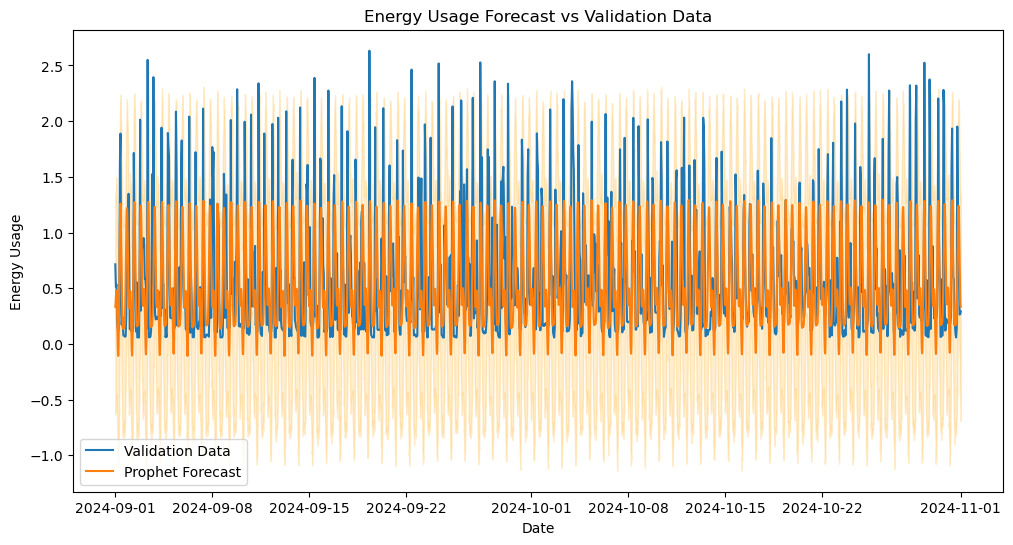

In [163]:
# plot 90 days of validation data and the prophet forecast
plt.figure(figsize=(12, 6))
plt.plot(validation_data_hourly['datetime'][:90*24], validation_data_hourly['value'][:90*24], label='Validation Data')
plt.plot(prophet_forecast_sept_oct['ds'], prophet_forecast_sept_oct['yhat'], label='Prophet Forecast')
plt.fill_between(prophet_forecast_sept_oct['ds'], prophet_forecast_sept_oct['yhat_lower'], prophet_forecast_sept_oct['yhat_upper'], alpha=0.2, color='orange')
plt.xlabel('Date')
plt.ylabel('Energy Usage')
plt.title('Energy Usage Forecast vs Validation Data')
plt.legend()
plt.show()